In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd
import pandas_profiling as pp
import seaborn as sns # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [46]:
titanic_train_data = pd.read_csv('../input/train.csv')
titanic_test_data = pd.read_csv('../input/test.csv')
#Analyse Titanic data
titanic_train_data.head()

titanic_train_data.info()
#Clean data and fill in missing values
#we can see many values are missing for 
titanic_train_data['Age'].isnull().sum()


titanic_train_data['Embarked'].isnull().sum()
titanic_train_data['Embarked'].fillna('S',inplace =True)
titanic_train_data['Embarked'].isnull().sum()
titanic_train_data['Embarked']

titanic_train_data.drop(['Cabin'],axis =1 ,inplace =True)
titanic_train_data.isnull().sum()

titanic_test_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


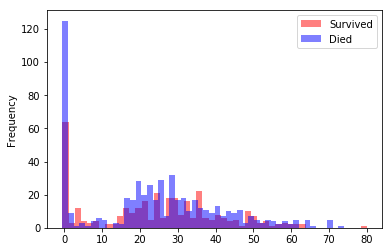

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in

    0   1
0  95  15
1  20  49
     0   1
0  103   7
1   26  43


0.8156424581005587

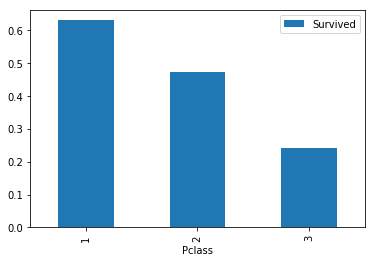

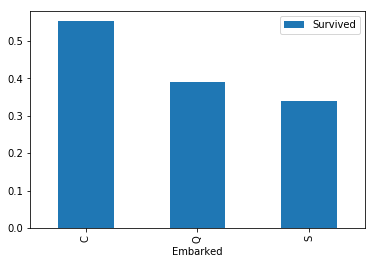

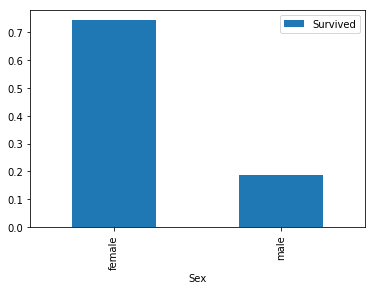

In [58]:


def create_dummies(df,col):
    dummies = pd.get_dummies(df[col],prefix=col)
    df = pd.concat([df,dummies],axis =1)
    return df
titanic_train_data = create_dummies(titanic_train_data,"Pclass")
titanic_test_data = create_dummies(titanic_test_data,"Pclass")
titanic_train_data = create_dummies(titanic_train_data,"Sex")
titanic_test_data = create_dummies(titanic_test_data,"Sex")
titanic_train_data = create_dummies(titanic_train_data,"Embarked")
titanic_test_data = create_dummies(titanic_test_data,"Embarked")

#convert age to dummy type

def process_age(df,cut_points,label_names):
    df["Age"] = df['Age'].fillna(-0.5)
    df["Age_categories"] = pd.cut(df['Age'],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult",'Senior']

titanic_train_data = process_age(titanic_train_data,cut_points,label_names)
titanic_test_data = process_age(titanic_test_data,cut_points,label_names)

survived = titanic_train_data[titanic_train_data["Survived"] == 1]
died = titanic_train_data[titanic_train_data["Survived"] == 0]
survived.Age.astype(int)
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

titanic_train_data = create_dummies(titanic_train_data,"Age_categories")
titanic_test_data = create_dummies(titanic_test_data,"Age_categories")

class_pivot = titanic_train_data.pivot_table(index = 'Pclass',values ='Survived')
class_pivot.plot.bar()

cabin_p = titanic_train_data.pivot_table(index = 'Embarked',values ='Survived')
cabin_p.plot.bar()
sex_p = titanic_train_data.pivot_table(index = 'Sex',values ='Survived')
sex_p.plot.bar()
titanic_test_data


#Training data set
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.preprocessing import StandardScaler
sc_x =StandardScaler()
titanic_train_data[columns] =sc_x.fit_transform(titanic_train_data[columns])
titanic_test_data[columns] =sc_x.fit_transform(titanic_test_data[columns])
titanic_train_data


#Since test data set doesnt have survived column, we will split our data into train and test
from sklearn.model_selection import train_test_split


all_X = titanic_train_data[columns]
all_y = titanic_train_data['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.2,random_state=0)


from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(train_X, train_y)


#Predicting results
predictions = classifier.predict(test_X)
predictions

#finding accuracy 
from sklearn.metrics import accuracy_score
accuracy_logistic = accuracy_score(test_y, predictions)
accuracy_logistic

from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(test_y, predictions))
print(cm)

from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_X, train_y)
random_forest_predictions = random_forest.predict(test_X)
acc_random_forest = round(random_forest.score(test_X, test_y) * 100, 2)

cm_random = pd.DataFrame(confusion_matrix(test_y, random_forest_predictions))
print(cm_random)
accuracy_random  = accuracy_score(test_y, random_forest_predictions)
accuracy_random




In [62]:
# Preparing data for Submission
test_random_forest_predictions = random_forest.predict(titanic_test_data[columns])
test_Survived = pd.Series(test_random_forest_predictions, name="Survived")
final = pd.concat([titanic_test_data.PassengerId,test_Survived],axis=1)
final
final.to_csv('titanic_results.csv', index=False)